In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches
from object_detection.utils import ops as utils_ops

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


%matplotlib inline

In [3]:
class ParkingLotDetector(object):
    def __init__(self):
        PATH_TO_MODEL = 'fine_tuned_model/frozen_inference_graph.pb'
        self.detection_graph = tf.Graph()
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            with tf.gfile.GFile(PATH_TO_MODEL, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')
            self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
            self.d_boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
            self.d_scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
            self.d_classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
            self.num_d = self.detection_graph.get_tensor_by_name('num_detections:0')
        self.sess = tf.Session(graph=self.detection_graph)
        
    
    def get_classification(self, img_path):
        
        image = ParkingLotDetector.load_image_into_numpy_array(Image.open(img_path))

        # Bounding Box Detection.
        with self.detection_graph.as_default():
            # Expand dimension since the model expects image to have shape [1, None, None, 3].
            img_expanded = np.expand_dims(image, axis=0)  
            (boxes, scores, classes, num) = self.sess.run(
                [self.d_boxes, self.d_scores, self.d_classes, self.num_d],
                feed_dict={self.image_tensor: img_expanded})
        return boxes, scores, classes, num
    
    @staticmethod
    def visualize(image_path, boxes, classes, scores, score_threshold):
        image = ParkingLotDetector.load_image_into_numpy_array(Image.open(image_path))
        width = image.shape[1]
        height = image.shape[0]

        fig,ax = plt.subplots(1)

        # add axes to the image
        ax = fig.add_axes([0, 0, 1, 1])

        # add bounding boxes to the image
        for index, score in enumerate(scores[0]):
            if score > score_threshold:
                y_min = boxes[0][index][0]*height
                x_min = boxes[0][index][1]*width
                y_max = boxes[0][index][2]*height
                x_max = boxes[0][index][3]*width
                occupancy = classes[0][index]

                color = 'r'
                if occupancy == 2:
                    color = 'b'

                box_width = x_max - x_min
                box_height = y_max - y_min

                rect = patches.Rectangle((x_min, y_min), box_width, box_height, edgecolor=color, facecolor='none')
                ax.add_patch(rect)

        ax.imshow(image)

    @staticmethod
    def load_image_into_numpy_array(image):
        (im_width, im_height) = image.size
        return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)
        

In [4]:
class TestSampleCollector:
    
    @staticmethod
    def load_test_sample():
        pk_dataset_path = '../pklot-dataset-modified/'
        test_ds_path = pk_dataset_path+'test/test.csv'
        test_imgs_path = pk_dataset_path+'test/images/'

        train = pd.read_csv(test_ds_path)
        train.head()

        index = random.randint(0, train.shape[0])
        path = train['img_path'][index]
        sample_img_path = test_imgs_path+path.split('/')[-1]

        boxes = []
        classes = []

        # iterating over the image for different objects
        for _, row in train[train.img_path == path].iterrows():

            occupancy = row.occupancy
            xmin = row.xmin
            ymin = row.ymin
            xmax = row.xmax
            ymax = row.ymax

            classes.append(occupancy)
            boxes.append([xmin, ymin, xmax, ymax])
        
        return sample_img_path, boxes, classes
    
    
    @staticmethod
    def visualize(img_path, boxes, classes):
        
        image = ParkingLotDetector.load_image_into_numpy_array(Image.open(img_path))
        
        fig = plt.figure()
        ax = fig.add_axes([0, 0, 1, 1])
        plt.imshow(image)
        
        for index, box in enumerate(boxes):
            occupancy = classes[index]
            xmin = box[0]
            ymin = box[1]
            xmax = box[2]
            ymax = box[3]

            if occupancy == 'free':
                edgecolor = 'b'
            else:
                edgecolor = 'r'

            width = xmax - xmin
            height = ymax - ymin

            # add bounding boxes to the image
            rect = patches.Rectangle((xmin, ymin), width, height, edgecolor=edgecolor, facecolor='none')
            ax.add_patch(rect)

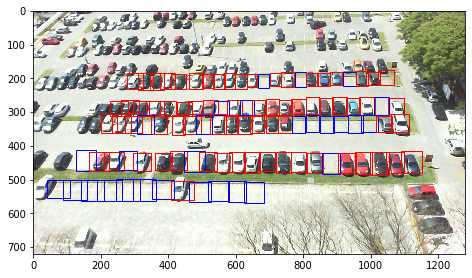

In [7]:
img_path, label_boxes, label_classes = TestSampleCollector.load_test_sample()

TestSampleCollector.visualize(img_path, label_boxes, label_classes)

In [9]:
detector = ParkingLotDetector()

In [10]:
pred_boxes, scores, pred_classes, num = detector.get_classification(img_path)

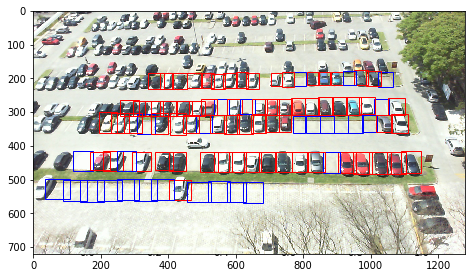

In [11]:
ParkingLotDetector.visualize(image_path=img_path,
                             boxes=pred_boxes,
                             classes=pred_classes,
                             scores=scores,
                             score_threshold=0.8)

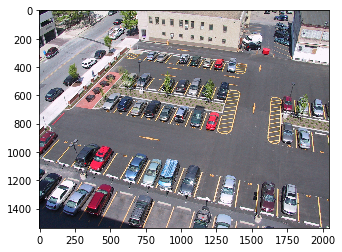

In [12]:
u_image_path = 'assets/unseen_pk_lot.jpg'

u_image = ParkingLotDetector.load_image_into_numpy_array(Image.open(u_image_path))
plt.imshow(u_image)

In [13]:
u_boxes, u_scores, u_classes, _ = detector.get_classification(u_image_path)

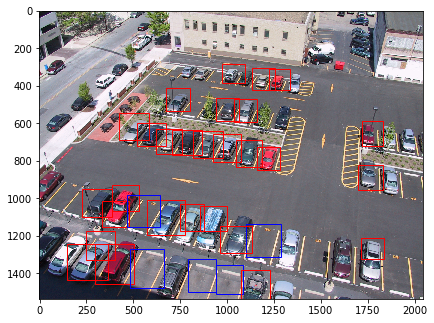

In [14]:
ParkingLotDetector.visualize(image_path=u_image_path,
                             boxes=u_boxes,
                             classes=u_classes,
                             scores=u_scores,
                             score_threshold=0.5)

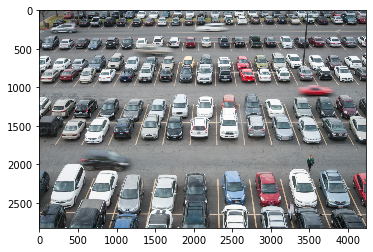

In [14]:
u_image_path_2 = 'assets/unseen3.jpg'

u_image_2 = ParkingLotDetector.load_image_into_numpy_array(Image.open(u_image_path_2))
plt.imshow(u_image_2)

In [15]:
u_boxes, u_scores, u_classes, _ = detector.get_classification(u_image_path_2)

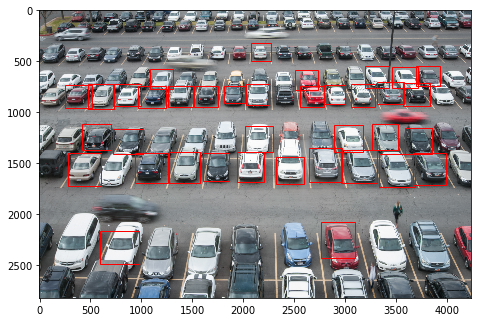

In [16]:
ParkingLotDetector.visualize(image_path=u_image_path_2,
                             boxes=u_boxes,
                             classes=u_classes,
                             scores=u_scores,
                             score_threshold=0.5)

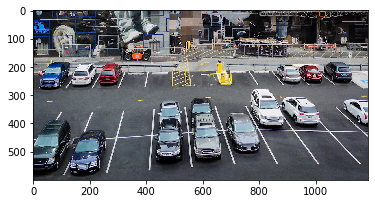

In [18]:
u_image_path_3 = 'assets/unseen4.jpg'

u_image_3 = ParkingLotDetector.load_image_into_numpy_array(Image.open(u_image_path_3))
plt.imshow(u_image_3)

In [19]:
u_boxes, u_scores, u_classes, _ = detector.get_classification(u_image_path_3)

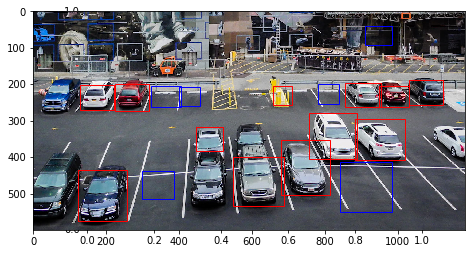

In [23]:
ParkingLotDetector.visualize(image_path=u_image_path_3,
                             boxes=u_boxes,
                             classes=u_classes,
                             scores=u_scores,
                             score_threshold=0.5)

In [15]:
import time
num_test_imgs = 10

start = time.time()

for i in range(num_test_imgs):
    img_path, _, _ = TestSampleCollector.load_test_sample()
    _, _, _, _ = detector.get_classification(img_path)
    
enlapsed = (time.time() - start)/float(num_test_imgs)

print('Average Speed [seconds/inference]: {}'.format(enlapsed))

Average Speed [inference/second]: 12.958337569236756


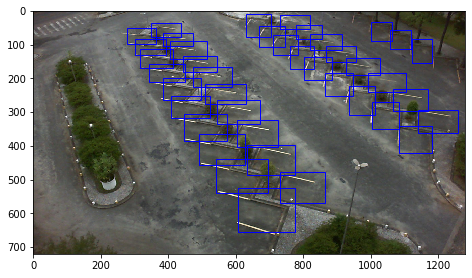